# Coding session 

In this first lab, we will delve into the realm of virtual screening. Using datasets of 2D molecules, we will develop predictive models to assess inhibitory activity against a human kinase EGFR(Epidermal Growth Factor Receptor) protein. Building on concepts from lectures on molecular representation, scoring, and Graph Neural Networks (GNNs) for Chemistry, we will utilize `PyTorch`,`PyG`, `Scikit-learn`, and other libraries to create both GNN models and classical Random Forest models with molecular fingerprints. 

**Discovery of novel EGFR inhibitors** \
We aim to leverage those publicly available data to identify more hits within the known chemical space. The ultimate objective is to screen the hinge binder library and select **100** promising and **diverse** molecules with molecular weight between **280 and 400 Da** for further experimental investigation.




To successfully apply ML, we need 
- a data set of molecules and bioactivities
- a molecular representation
- a ML algorithm to train a model 
- appropriate evaluation strategy which suits project objectives. 

Then, we can make predictions for new molecules.

#  Outline
- Data analysis
- Molecular representation
- Model training and evaluation
  - ECFP + Random forest regressor 
  - GNN model
- Virtual screening 
- Compound prioritization


In [5]:
# # Run the code below for setting up google colab enviroment
# # install condacolab
# !pip install -q condacolab
# import condacolab
# condacolab.install()

# # copy from github
# !git clone https://github.com/valence-labs/mtl_summer_school_2024.git

# # change working directory
# import os
# os.chdir("/content/mtl_summer_school_2024/Lab1")

# # install dependencies
# !mamba env update -n base -f env.yml

## Leveraging public data

The popular public databases for chemicals and bioactivities:

- Pubchem: 118M Compounds for 295M Bioactivities
- ChEMBL:  2.43M Compounds for 20.7M Bioactivities
- Others: BindingDB, KLIFS, clue.io, etc.

**Readouts for EGFR inhibition**: 
- %inhibition at different concentrations (uM, nM)
- IC50:  Inhibitory concentration 50%

<img src="figures/IC50_determination_illustration.png" width="400"/>

- $pIC_{50} = -log_{10}(IC_{50})$
  
<img src="figures/logistic_vs_loglogistic1.png" width="500"/>

- Inhibition constant (Ki), Dissociation constant (Kd)

### Load compound and activity data

Let’s start by loading our data. The csv file is loaded into a dataframe with the important columns:

- `MOL_smiles`: SMILES string of the corresponding compound.

- `pIC50`: Measured inhibition.

In [2]:
import pandas as pd
import datamol as dm
import numpy as np
import os

os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

# load pre-processed data
data = pd.read_csv("data/egfr_pIC50_tutorial.csv")
mol_col = "MOL_smiles"
data_col = "pIC50"

In [3]:
# Look at head
print("Shape of dataframe : ", data.shape)
data.head()

Shape of dataframe :  (4396, 4)


,MOL_smiles,pIC50,Gene_Symbol,Original_Entry_ID
0,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4nc5ccccc5s4)c(Cl)...,6.73,EGFR,CHEMBL175513
1,O=C1NC(=O)c2cc(Nc3ccccc3)c(Nc3ccccc3)cc21,6.80,EGFR,CHEMBL268868
2,CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc5sncc45)c(Cl...,8.54,EGFR,CHEMBL2048906
3,CCOc1ccc(-c2nn(C3CCCC3)c3ncnc(N)c23)cc1OC,5.85,EGFR,CHEMBL1240554
4,C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1,9.70,EGFR,CHEMBL553


To define an active compound, an activity cut-off ranging from an pIC50 value of 5 to 7 in drug discovery programs. 

In this tutorial, we use a pIC50 value of 6 which is commonly used to define an active compound. 

pIC50 = 6 => IC50 1uM



Text(3, 550, 'IC50=10 uM ')

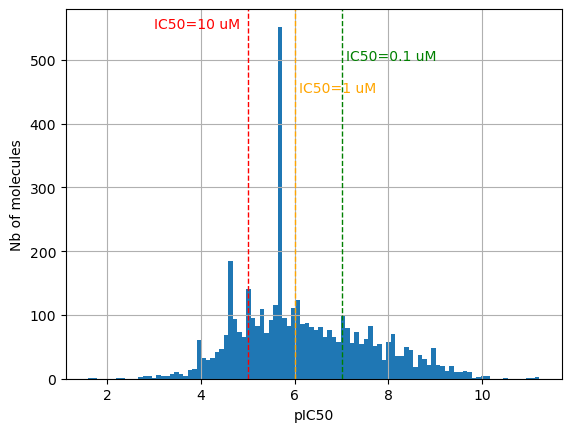

In [4]:
from matplotlib import pyplot as plt

fig = data[data_col].hist(bins=100)
plt.xlabel("pIC50")
plt.ylabel("Nb of molecules")
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(5, color="red", linestyle="dashed", linewidth=1)
fig.annotate("IC50=10 uM ", xy=(3, 550), xytext=(3, 550), color="red")

### Distribution in the chemical space
The screening library covers the dataset within the chemical space.

<img src="figures/lib_chemspace.png" width="800"/>

## Molecular representation
For ML, molecules need to be converted into features/representation.
In this tutorial, we will focus on **Fingerprint** and **Molecular Graph**.

### Morgan fingerprints ECFP
Extended-Connectivity Fingerprints (ECFPs) are circular topological fingerprints designed for molecular characterization, similarity searching, and structure-activity modeling. We use the implementation from RDKit which is called Morgan fingerprint.

The two most important parameters of these fingerprints are the `radius` and `fingerprint length`. The first specifies the radius of circular neighborhoods considered for each atom. The length parameter specifies the length to which the bit string representation is hashed.


<img src="figures/ecfp_generation.png" width="800"/>

<img src="figures/ecfp_folding.png" width="800"/>

The RDKit implementation is avalaible in [molfeat](https://molfeat.datamol.io/), which is a hub for all molecular featurizers.

In [5]:
from molfeat.trans.fp import FPVecTransformer

fp_transformer = FPVecTransformer(kind="ecfp:4", length=2048)
features = fp_transformer(data[mol_col].values)

# or use `datamol.to_fp`
# features = np.array([dm.to_fp(smi) for smi inn data[mol_col].values])

print(features)
features.shape

/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


(4396, 2048)

In [6]:
# get the inhibition values
activities = data[data_col].values
activities

array([6.73, 6.8 , 8.54, ..., 6.21, 6.25, 5.8 ])

Use those molecular fingerprints as features as the inputs for ML model.

<img src="figures/fp_ml.png" width="300"/>

In [7]:
FPVecTransformer.AVAILABLE_FPS

['maccs',
 'avalon',
 'pattern',
 'layered',
 'map4',
 'secfp',
 'erg',
 'estate',
 'avalon-count',
 'ecfp',
 'fcfp',
 'topological',
 'atompair',
 'rdkit',
 'ecfp-count',
 'fcfp-count',
 'topological-count',
 'atompair-count',
 'rdkit-count',
 'desc3D',
 'desc2D',
 'mordred',
 'cats2D',
 'cats3D',
 'pharm2D',
 'pharm3D',
 'scaffoldkeys',
 'skeys',
 'electroshape',
 'usr',
 'usrcat']

In [8]:
# Exercise 1: Custom featurization
# How to best featurize a molecule depends on the task you're trying to solve.
# In this example, we used ECFP. Datamol.io `molfeat` offers a range of other featurization schemes that
# may perform better. Try out a few different options by overwriting the features variable.

# === YOUR CODE GOES HERE ===
fp_transformer = FPVecTransformer(kind="maccs", length=2048)
features = fp_transformer(data[mol_col].values)

# === END ===

###  Molecular graph representation

<img src="figures/graph.png" width="500"/>

Below we convert the smiles to pyg graph object directly using `PYGGraphTransformer` from `molfeat`.

Each graph in our dataset is encapsulated in a PyG Data object, a convient way of representing all structured data for use in Geometric Deep Learning (including graphs, point clouds, and meshes).

In [9]:
### Process smiles into `torch_geometric.Data` objects
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True)

# convert Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()
pyg_features = transformer(mols)

100%|██████████████████████████████████████████████████████████████████| 4396/4396 [00:01<00:00, 2427.81it/s]


In [10]:
#### Example of a molecular graph object
pyg_mol = pyg_features[0]
pyg_mol

Data(x=[43, 82], edge_index=[2, 94])

In [11]:
# Visualize the adjacent matrix of the above graph object
from torch_geometric.utils import to_dense_adj

to_dense_adj(pyg_mol.edge_index)

tensor([[[0., 1., 0.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 1., 1.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.]]])

=> We can use pyg graph object as input for GNN modeling for inhibition prediction.

## Model training

The goal is to test the ability of the model to predict data which it has never seen before in order to flag problems known as over fitting and to assess the generalization ability of the model.

We start by defining a function model_performance which evaluate a model on a **train-test split** of the data and returns measures such as `mean_squared_error`, `pearsonr` and `spearmanr` evaluated on the heldout test set. We also plot the scatter plot of the true bioactivity and predictions with a linear regression model fit.

#### Utility functions

In [12]:
from loguru import logger
import torch
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, precision_recall_fscore_support

In [13]:
# Metrics
def pearsonr(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a pearson r correlation"""
    return stats.pearsonr(y_true, y_pred).statistic


def spearman(y_true: np.ndarray, y_pred: np.ndarray):
    """Calculate a Spearman correlation"""
    return stats.spearmanr(y_true, y_pred).statistic


def model_performance(
    ml_model, test_x, test_y, threshold=6, verbose=True, reg_plot: bool = True, device="cpu"
):
    """
    Helper function to calculate model performance

    Args
    ----------
    ml_model: model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)
    reg_plot: bool
        Scatter plot between predicion and true values.

    Returns
    -------
    tuple:
        MSE, Pearson R, Spearman, Precision, Recall and Fsocre on test set.
    """

    # Prediction class on test
    if isinstance(ml_model, RandomForestRegressor):
        test_pred = ml_model.predict(test_x)
    else:
        ml_model.eval()  # set model to evaluate mode
        test_pred = torch.cat([ml_model.predict(x.to(device)) for x in test_x]).detach().cpu().numpy().flatten()

    # Performance of model on test set
    ## regression
    mse = mean_squared_error(test_y, test_pred)
    pearsonr_score = pearsonr(test_y, test_pred)
    spearman_score = spearman(test_y, test_pred)
    ## classification
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_true=test_y > threshold, y_pred=test_pred > threshold, average="binary"
    )

    if verbose:
        # Print performance results
        logger.info(f"mean_squared_error: {mse:.2f}")
        logger.info(f"pearson r: {pearsonr_score:.2f}")
        logger.info(f"spearman: {spearman_score:.2f}")
        logger.info(f"precision: {precision:.2f}")
        logger.info(f"recall: {recall:.2f}")
        logger.info(f"fscore: {fscore:.2f}")

    if reg_plot:
        plot_df = pd.DataFrame({"y_true": test_y, "y_pred": test_pred})
        sns.set_style("whitegrid")
        fig = sns.regplot(data=plot_df, x="y_true", y="y_pred")
        fig.axvline(threshold, color="orange", linestyle="dashed", linewidth=1)
        fig.axhline(threshold, color="orange", linestyle="dashed", linewidth=1)

    return mse, pearsonr_score, spearman_score, precision, recall, fscore

#### Data splitting for hit identification

<img src="figures/lib_chemspace.png" width="800"/>

Let's create split data into train and test set. The splits will be shared with all the models. 

**Scaffold splitting** is approach that identifies chemical series or scaffolds in the dataset and moving all molecules sharing one or more scaffolds to the test set. \
The **goal** is to evaluate how well a model performs on scaffolds and regions of chemical space that differ from those it was trained on. 

In [14]:
from splito._scaffold_split import get_scaffold

# compute Murcko scaffolds
scaffolds = dm.utils.parallelized(
    fn=get_scaffold, inputs_list=data[mol_col].tolist(), n_jobs=-1, progress=True
)
print(
    f"There are unique {len(set(scaffolds))} scaffolds for {len(data)} molecules in the dataset."
)

100%|██████████████████████████████████████████████████████████████████| 4396/4396 [00:01<00:00, 2325.20it/s]

There are unique 1777 scaffolds for 4396 molecules in the dataset.


In [15]:
# Create scaffold-base train-test split
from splito import ScaffoldSplit, MaxDissimilaritySplit, PerimeterSplit
spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=5, test_size=0.2, random_state=111
)
train_index, test_index = next(spliter.split(features))

print("Training data size:", len(train_index))
print("Test data size:", len(test_index))

Training data size: 3355
Test data size: 1041


/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


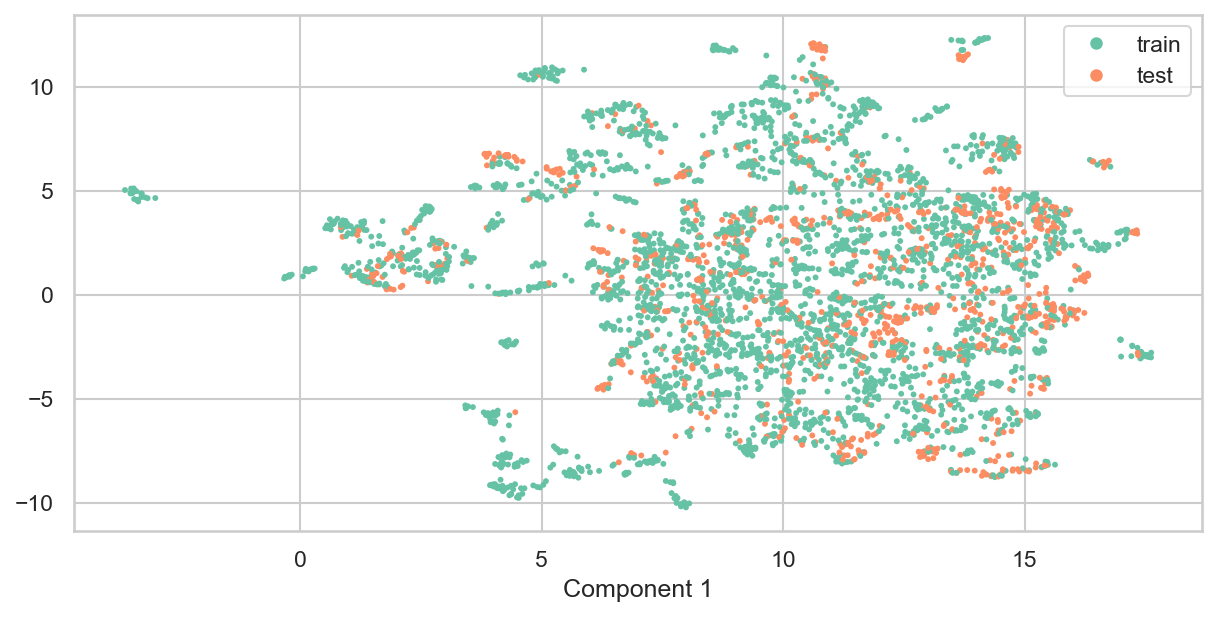

In [16]:
# Visualize their distribution within the chemical space
from chemspace_viz import visualize_chemspace

split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(
    X=features, y=[split_labels], metric="jaccard", min_dist=0.5, random_state=42
)

=> Diverse scaffolds in the dataset.

In [17]:
# Exercise 2: Choice of splitting method

# In this example, we used scaffold based spliting approach. Datamol.io `splito` offers a range of other splitting method schemes.
# Now we want to adjust the project objective to discovery novel further away from the chemical space of the training set.
# Try out a few different splitting methods, and observe the distribution and their impact on model performance.
# Checkout `splito.PerimeterSplit`.

# === YOUR CODE GOES HERE ===
# I'm using structure-based splitting methods since they are designed to 
# increase the distance btw the train and test sets in a bid to optimize for generation capability
spliter = PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=20)
# spliter = MaxDissimilaritySplit(n_jobs=-1, test_size=0.2, random_state=20)
train_index, test_index = next(spliter.split(features))

print(f"Training set size = {len(train_index)}")
print(f"Testing set size = {len(test_index)}")
#
# === END ===

Training set size = 3425
Testing set size = 971


/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


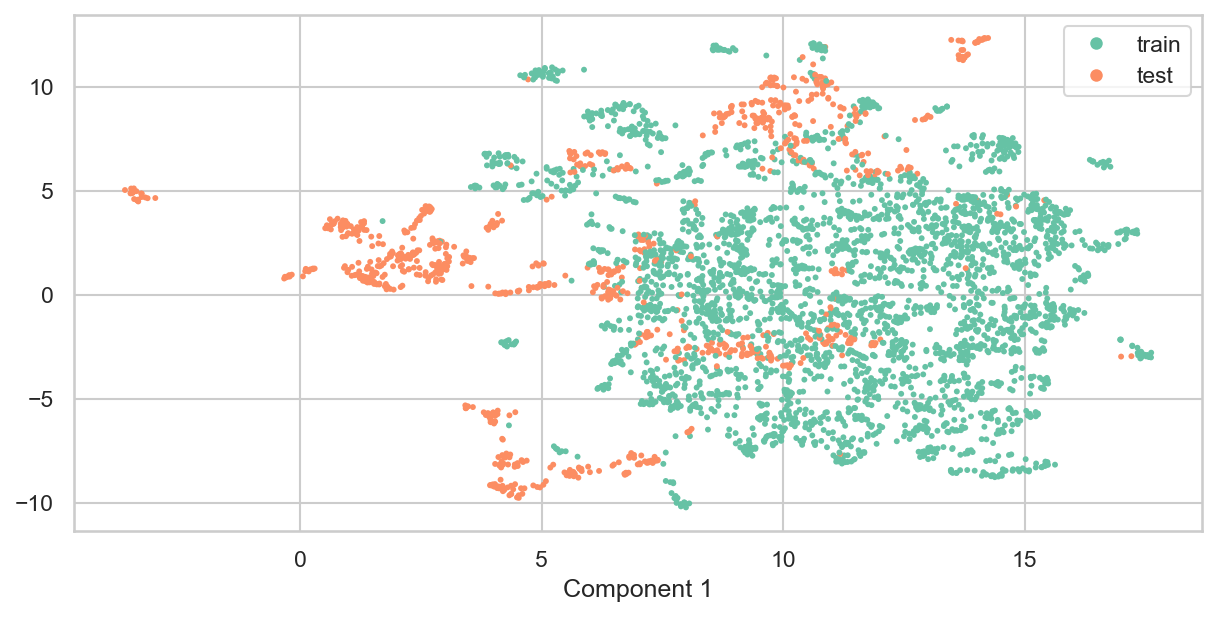

In [18]:
# Visualize their distribution within the chemical space
from chemspace_viz import visualize_chemspace

split_labels = np.full(len(features), "train", dtype=object)
split_labels[test_index] = "test"
fig = visualize_chemspace(
    X=features, y=[split_labels], metric="jaccard", min_dist=0.5, random_state=42
)

#### Random forest regressor for inhibition prediction

In [19]:
# Get the features and bioactivities of the training set
train_x, train_y = features[train_index], activities[train_index]

print("Training set data shape:", train_x.shape)

Training set data shape: (3425, 167)


In [20]:
# Define a model and train
from sklearn.ensemble import RandomForestRegressor

# Set model parameter for random forest
rf_param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "squared_error",  # cost function to be optimized for a split
}

RF_model = RandomForestRegressor(**rf_param)

In [21]:
# Fit model on single train split
RF_model.fit(train_x, train_y)

RandomForestRegressor()

2024-09-04 14:06:30.263 | INFO     | __main__:model_performance:56 - mean_squared_error: 0.78
2024-09-04 14:06:30.264 | INFO     | __main__:model_performance:57 - pearson r: 0.76
2024-09-04 14:06:30.264 | INFO     | __main__:model_performance:58 - spearman: 0.72
2024-09-04 14:06:30.264 | INFO     | __main__:model_performance:59 - precision: 0.84
2024-09-04 14:06:30.264 | INFO     | __main__:model_performance:60 - recall: 0.76
2024-09-04 14:06:30.264 | INFO     | __main__:model_performance:61 - fscore: 0.80


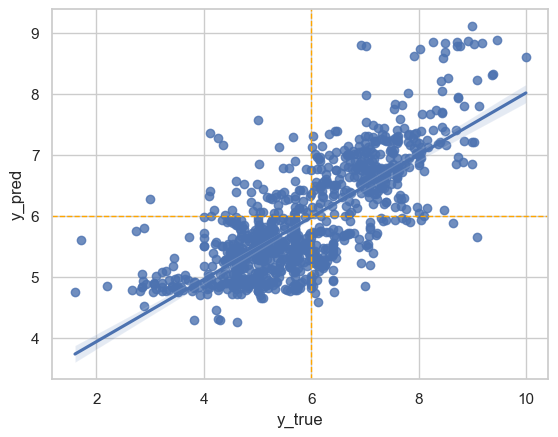

In [22]:
# Get the features and bioactivities of the test set
test_x, test_y = features[test_index], activities[test_index]

# Compute the performance and generate the plot
res = model_performance(RF_model, test_x, test_y, verbose=True, threshold=6)

In [23]:
# Dump the transformer and model to pickle file
import pickle

with open("model/rf_regressor.pkl", "wb") as fout:
    pickle.dump((fp_transformer, RF_model), fout)

#### Validation on scaffold-based splits
<img src="figures/sphx_glr_plot_cv_indices_011.png" width="500"/>



In [24]:
# define cross validation process and metrics

from sklearn import clone


def cross_validation(
    ml_model, spliter, features, activities, verbose=True, threshold=6
):
    """
    Machine learning model training and validation in a cross-validation loop.
    """
    # Results for each of the cross-validation folds
    pearsonr_per_fold = []
    spearman_per_fold = []
    mse_per_fold = []
    precision_per_fold = []
    recall_per_fold = []
    fscore_per_fold = []

    # Loop over the folds
    for train_index, test_index in spliter.split(features):

        # clone the newly initiated model
        fold_model = clone(ml_model)

        # Training

        # Convert the fingerprint and the label to a list
        train_x = features[train_index]
        train_y = activities[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = features[test_index]
        test_y = activities[test_index]

        # Performance for each fold
        mse, pearsonr_score, spearman_score, precision, recall, fscore = (
            model_performance(
                ml_model=fold_model,
                test_x=test_x,
                test_y=test_y,
                verbose=verbose,
                threshold=threshold,
                reg_plot=False,
            )
        )

        # Save results
        mse_per_fold.append(mse)
        pearsonr_per_fold.append(pearsonr_score)
        spearman_per_fold.append(spearman_score)
        precision_per_fold.append(precision)
        recall_per_fold.append(recall)
        fscore_per_fold.append(fscore)

    # Print statistics of results
    print(
        f"Mean mean squared error: {np.mean(mse_per_fold):.2f} \t"
        f"and std : {np.std(mse_per_fold):.2f} \n"
        f"Mean pearsonr: {np.mean(pearsonr_per_fold):.2f} \t"
        f"and std : {np.std(pearsonr_per_fold):.2f} \n"
        f"Mean spearman: {np.mean(spearman_per_fold):.2f} \t"
        f"and std : {np.std(spearman_per_fold):.2f} \n"
        f"Mean precision: {np.mean(precision_per_fold):.2f} \t"
        f"and std : {np.std(precision_per_fold):.2f} \n"
        f"Mean recall: {np.mean(recall_per_fold):.2f} \t"
        f"and std : {np.std(recall_per_fold):.2f} \n"
        f"Mean fscore: {np.mean(fscore_per_fold):.2f} \t"
        f"and std : {np.std(fscore_per_fold):.2f} \n"
    )

    meric_per_fold = {
        "mse": mse_per_fold,
        "pearsonr": pearsonr_per_fold,
        "spearman": spearman_per_fold,
        "precision": precision_per_fold,
        "recall": recall_per_fold,
        "fscore": fscore_per_fold,
    }
    sns.boxplot(meric_per_fold, palette="pastel").set(
        title="Evaluation cross 10 splits"
    )

In [25]:
# # spliter = ScaffoldSplit(
# #     smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
# # )
# spliter = MaxDissimilaritySplit(test_size=0.2, n_jobs=-1, random_state=111)

# cross_validation(
#     ml_model=RandomForestRegressor(**rf_param),
#     spliter=spliter,
#     features=features,
#     activities=activities,
#     threshold=6,
#     verbose=False,
# )

Mean mean squared error: 0.98 	and std : 0.22 
Mean pearsonr: 0.69 	and std : 0.04 
Mean spearman: 0.68 	and std : 0.03 
Mean precision: 0.75 	and std : 0.03 
Mean recall: 0.82 	and std : 0.04 
Mean fscore: 0.78 	and std : 0.03 



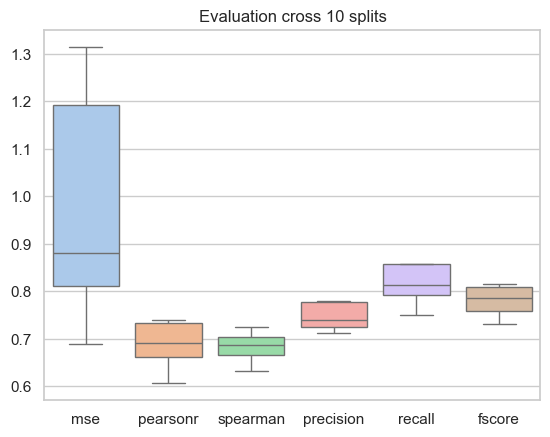

In [26]:
spliter = ScaffoldSplit(
    smiles=data[mol_col].values, n_splits=10, test_size=0.2, random_state=111
)
# spliter = MaxDissimilaritySplit(test_size=0.2, n_jobs=-1, random_state=111)

cross_validation(
    ml_model=RandomForestRegressor(**rf_param),
    spliter=spliter,
    features=features,
    activities=activities,
    threshold=6,
    verbose=False,
)

In [27]:
# spliter = PerimeterSplit(n_jobs=-1, test_size=0.2, random_state=111)

# cross_validation(
#     ml_model=RandomForestRegressor(**rf_param),
#     spliter=spliter,
#     features=features,
#     activities=activities,
#     threshold=6,
#     verbose=False,
# )

<!-- <img src="figures/validation.png" width="500"/> -->



#### Graph neural network for inhibition prediction

<img src="figures/gnn_ml.png" width="800"/>

Here we try to train a graph neural network model with 3 convolutional layers and a followed by a linear transformer for final output.

In [28]:
import torch
from gnn import GCNModel

# Define the graph model
# Use CUDA if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # using mps on my mac
# Create network and send to the device memory
gnn_model = GCNModel(
    in_channels=transformer(mols[0])[0].x.shape[1],
    hidden_channels=128,
    out_channels=1,
    num_layers=3,
    is_reg=True,
).to(device)

# Use Adam optimizer
optimizer = torch.optim.Adam(gnn_model.parameters(), lr=0.001, weight_decay=0)

# Define the loss function
loss_fn = torch.nn.MSELoss()

In [29]:
torch.backends.mps.is_available()

True

In [30]:
# Display the GNN model
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=1, bias=True)
)

In [31]:
from molfeat.trans.graph.adj import PYGGraphTransformer

# convert smiles to Rdkit.Mol object
mols = np.array(dm.parallelized(fn=dm.to_mol, inputs_list=data[mol_col], progress=True))

# converT Rdkit.Mol object to `torch_geometric.Data` object
transformer = PYGGraphTransformer()

train_set = []
for index in train_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    train_set.append(pyg_data)

test_set = []
for index in test_index:
    pyg_data = transformer(mols[index])[0]
    pyg_data.y = torch.from_numpy(np.array([activities[index]])).to(torch.float32)
    test_set.append(pyg_data)

100%|██████████████████████████████████████████████████████████████████| 4396/4396 [00:00<00:00, 7126.91it/s]


Batching graphs can often be a tedious and intricate process. Fortunately, PyG simplifies this task significantly! With a list of Data objects, we can effortlessly batch them into a PyG Batch object and also unbatch them back into individual graphs. Moreover, for straightforward scenarios like ours, the PyG DataLoader object takes care of all the batching automatically.

In [32]:
# Create dataloaders with batch size 8
from torch_geometric.loader import DataLoader

batch_size = 8

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Training loop ...

In [33]:
from loguru import logger
from tqdm import tqdm

num_epoch = 5

# train model
# set model to training mode
gnn_model.train()

# run for epochs of training
for epoch in range(num_epoch):
    sum_loss = 0  # used to compute average loss in an epoch

    # go over each training batches
    for batch in tqdm(train_loader):
        batch = batch.to(device)  # send data to device
        optimizer.zero_grad()  # zero gradients

        # #evaluate data point
        out = gnn_model(batch)
        loss = loss_fn(out, batch.y)  # compute the loss
        sum_loss += float(loss)  # Add loss value to aggregate loss

        # compute gradients
        loss.backward()
        # apply optimization

        optimizer.step()
    logger.info(
        "Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss / len(train_set))
    )

  0%|                                                                                | 0/429 [00:00<?, ?it/s]/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/torch_geometric/utils/_scatter.py:100: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1725435478078/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(
/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 99%|█████████████████████████████

2024-09-04 14:08:07.996 | INFO     | __main__:model_performance:56 - mean_squared_error: 1.88
2024-09-04 14:08:07.999 | INFO     | __main__:model_performance:57 - pearson r: 0.43
2024-09-04 14:08:08.000 | INFO     | __main__:model_performance:58 - spearman: 0.45
2024-09-04 14:08:08.000 | INFO     | __main__:model_performance:59 - precision: 0.44
2024-09-04 14:08:08.001 | INFO     | __main__:model_performance:60 - recall: 0.98
2024-09-04 14:08:08.001 | INFO     | __main__:model_performance:61 - fscore: 0.61


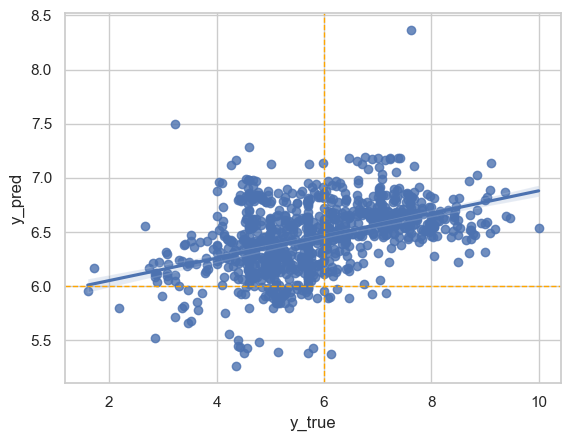

In [34]:
# Compute the performance and generate the plot

res = model_performance(gnn_model, test_loader, test_y, verbose=True, threshold=6, device=device)

#### Hyperparameter tuning

Hyperparameter tuning is the process of selecting the best set of parameters for a machine learning model and the dataset to improve the performance.

One can perform efficient HP tuning by using frameworks, such as **Optuna** and **Weights & Biases sweep**.

=> train/validation/test set

<img src="figures/HP_tuning.png" width="800"/>

In [41]:
# Exercise 3: Classifier

# Instead of a regressor, try to train the classifiers,
# and predict the inhibition class (inhbitor, non inhibitor) of the dataset.

# === YOUR CODE GOES HERE ===
gnn_model = GCNModel(
    in_channels=transformer(mols[0])[0].x.shape[1],
    hidden_channels=128,
    out_channels=2,
    num_layers=3,
    is_reg=False,
).to(device)

# === END ===

In [36]:
gnn_model

GCNModel(
  (conv_layers): ModuleList(
    (0): GCNConv(82, 128)
    (1-3): 3 x GCNConv(128, 128)
  )
  (out): Linear(in_features=256, out_features=2, bias=True)
)

In [44]:
# === YOUR CODE GOES HERE ===

#In this tutorial, we use a pIC50 value of 6 which is commonly used to define an active compound. 
# training the model defined in Ex 3 & 4
gnn_model.train()

loss_fn = torch.nn.CrossEntropyLoss() # since the final output of gnn model is the logits from the linear layer


for epoch in range(num_epoch):
    sum_loss=0
    for batch in tqdm(train_loader):
        bx = batch.to(device)
        optimizer.zero_grad()

        out = gnn_model(bx)
        loss = loss_fn(out, (bx.y>=6).long()) # the cut off is 6, do greater than 1 is active compd (inhibitor)

        sum_loss+=float(loss)
        
        loss.backward()

        optimizer.step()

    logger.info("Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss/len(train_set)))

100%|██████████████████████████████████████████████████████████████████████| 429/429 [00:09<00:00, 44.68it/s]
2024-09-04 14:22:47.083 | INFO     | __main__:<module>:26 - Epoch: 000, Average loss: 0.09635
100%|██████████████████████████████████████████████████████████████████████| 429/429 [00:09<00:00, 45.12it/s]
2024-09-04 14:22:56.593 | INFO     | __main__:<module>:26 - Epoch: 001, Average loss: 0.09635
100%|██████████████████████████████████████████████████████████████████████| 429/429 [00:09<00:00, 45.94it/s]
2024-09-04 14:23:05.933 | INFO     | __main__:<module>:26 - Epoch: 002, Average loss: 0.09636
100%|██████████████████████████████████████████████████████████████████████| 429/429 [00:08<00:00, 47.69it/s]
2024-09-04 14:23:14.931 | INFO     | __main__:<module>:26 - Epoch: 003, Average loss: 0.09637
100%|██████████████████████████████████████████████████████████████████████| 429/429 [00:07<00:00, 54.30it/s]
2024-09-04 14:23:22.833 | INFO     | __main__:<module>:26 - Epoch: 004, Av

In [45]:
# Exercise 4: Graph representation learning with graphium
from graphium.nn.pyg_layers import GCNConvPyg
# Instead of `pyg`, try use Datamol.io `graphium` to train graph-based model.
# Tutorials are available at https://graphium-docs.datamol.io

# === YOUR CODE GOES HERE ===
gnn_config = {
    'in_dim':transformer(mols[0])[0].x.shape[1], 
    'out_dim':128,
    'activation':"relu", 
    'dropout':.3, 
    'normalization':"batch_norm"
}
gnn_model = torch.nn.Sequential(GCNConvPyg( **gnn_config), torch.nn.Linear(128 * 2, 2) )

# === END ===

In [ ]:
# === YOUR CODE GOES HERE ===

#In this tutorial, we use a pIC50 value of 6 which is commonly used to define an active compound. 
# training the model defined in Ex 3 & 4
gnn_model.train()

loss_fn = torch.nn.CrossEntropyLoss() # since the final output of gnn model is the logits from the linear layer

for epoch in range(num_epoch):
    sum_loss=0
    for batch in tqdm(train_loader):
        bx = batch.to(device)
        optimizer.zero_grad()

        out = gnn_model(bx)
        loss = loss_fn(out, (bx.y>6).long()) # the cut off is 6, do greater than 1 is active compd (inhibitor)

        loss.backward()

        optimizer.step()

    logger.info("Epoch: {:03d}, Average loss: {:.5f}".format(epoch, sum_loss/len(train_set)))

# Virtual screening 

We have successfully trained several models. The next step is to use these models to predict binding affinity with an unknown screening dataset to discover novel potential EGFR inhibitors.

For demonstration purposes, we will perform virtual screening on a smaller library of 24,000 compounds specifically designed for discovering novel kinase ATP pocket binders.

In [47]:
import pickle
import numpy as np
import datamol as dm

In [48]:
# load commercial screening library
lib_path = "data/Enamine_Hinge_Binders_Library_plated_24000cmds_20210316.sdf"
lib_df = dm.read_sdf(lib_path, as_df=True, mol_column="mol")

#### Library statistics

In [49]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1ceff0>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x32c1cd5b0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfed0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfdf0>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1ce110>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3


In [50]:
lib_df.describe(include="all")

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds
count,24000,24000,24000,24000,24000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
unique,24000,24000,24000,300,80,NaN,NaN,NaN,NaN,NaN
top,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1ceff0>,Z57603637,1252574-R-230,A02,NaN,NaN,NaN,NaN,NaN
freq,1,1,1,80,300,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,348.377242,2.339357,1.406417,75.599830,4.600583
std,NaN,NaN,NaN,NaN,NaN,53.655375,1.339740,0.738477,19.544894,1.584347
min,NaN,NaN,NaN,NaN,NaN,177.226000,-2.841000,0.000000,19.370000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,312.409000,1.418000,1.000000,61.880000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,341.336000,2.370000,1.000000,74.610000,5.000000
75%,NaN,NaN,NaN,NaN,NaN,382.502250,3.250000,2.000000,87.910000,6.000000


### Load the pre-trained models and transformers

In [62]:
# load the fingerprint transformer and random forest model for EGFR binding affinity
with open("model/rf_regressor.pkl", "rb") as f:
    fp_transformer, rf_model = pickle.load(f)

### Scoring the compounds library with the predictive models

Let's begin by defining a scoring function that converts the molecular SMILES to feature inputs for the predictive models and predicts the pIC50 values.

In [63]:
import torch
from gnn import GCNModel


def score(mol, transformer, model, is_reg=True):
    try:
        # compute the molecular features
        feat = transformer(mol)
        if isinstance(model, GCNModel): 
            feat = transformer.get_collate_fn()(transformer(mol))[0]
        # score the molecule
        if is_reg:
            score = model.predict(feat)
        else:
            score = model.predict_proba(feat)[:, 1]
        if torch.is_tensor(score):
            score = score.flatten().numpy()
    except Exception as e:
        score = None
    return score

### Make predictions on pIC50

In [64]:
# Parallelize the scoring
lib_df["rf_preds_pIC50"] = dm.utils.parallelized_with_batches(
    fn=lambda mol: score(mol, fp_transformer, rf_model),
    inputs_list=lib_df.smiles.values,
    batch_size=1000,
    progress=True,
)

  0%|                                                | 0/24 [00:00<?, ?it/s]python(2404) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2405) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2406) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2407) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2408) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2409) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2410) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(2411) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|███████████████████████████████████████| 24/24 [00:18<00:00,  1.28it/s]


In [65]:
lib_df.head(5)

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1ceff0>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,5.496237
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x32c1cd5b0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,5.953200
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfed0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,5.485877
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfdf0>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,5.324400
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1ce110>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,4.988600


## Compound prioritization

Number of compounds having predicted pIC50 greater than 6:  8818
Number of compounds having predicted pIC50 greater than 7:  992


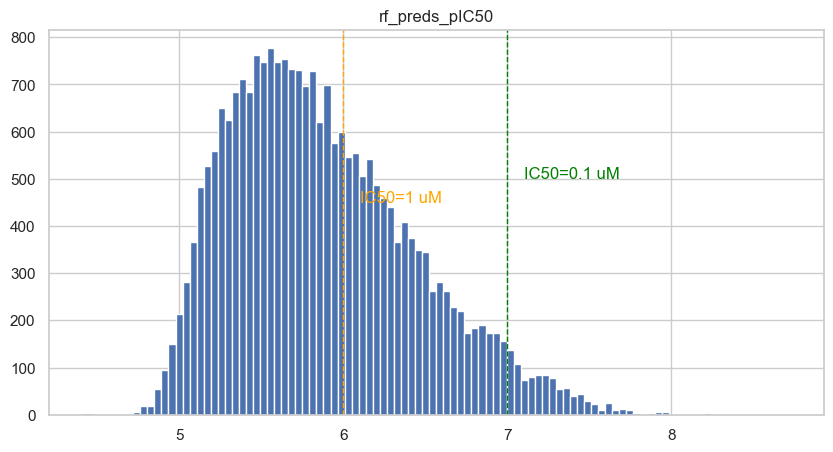

In [66]:
fig = lib_df[["rf_preds_pIC50"]].hist(bins=100, figsize=(10, 5))[0][0]
fig.axvline(6, color="orange", linestyle="dashed", linewidth=1)
fig.annotate("IC50=0.1 uM ", xy=(7, 500), xytext=(7.1, 500), color="green")
fig.axvline(7, color="green", linestyle="dashed", linewidth=1)
fig.annotate("IC50=1 uM", xy=(6, 450), xytext=(6.1, 450), color="orange")

print(
    "Number of compounds having predicted pIC50 greater than 6: ",
    lib_df["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df["rf_preds_pIC50"].gt(7).sum(),
)

### Filter molecules by predicted pIC50 values

In [67]:
lib_df_selected = lib_df.query("rf_preds_pIC50 > 6.5")
len(lib_df_selected)

3481

#### Filter molecules by the desired molecular weight 280 ~ 400 Dalton

In [68]:
lib_df_selected = lib_df_selected[lib_df_selected["MW (desalted)"].between(280, 400)]
len(lib_df_selected)

2523

### Exclude the possible repeated molecules between training set and prioritized set
We have to make sure that non of the prioritiezed compounds are already in the training set. \
Therefore, we compare the `unique_id` of molecules, and exlude the repeated molecules from the prioritized set.

In [71]:
import pandas as pd

# Compute the unique id
data_train = pd.read_csv("data/egfr_pIC50.csv")
data_train["uid"] = data_train["MOL_smiles"].apply(
    lambda smi: dm.unique_id(dm.to_mol(smi))
)
lib_df_selected.loc[:, "uid"] = lib_df_selected["mol"].apply(dm.unique_id).values


# Exclude the molecules in training set from the prioritized set
lib_df_selected = lib_df_selected.query("uid not in @data_train.uid")

len(lib_df_selected )

2522

Number of compounds having predicted pIC50 greater than 6.5:  2522
Number of compounds having predicted pIC50 greater than 7:  711


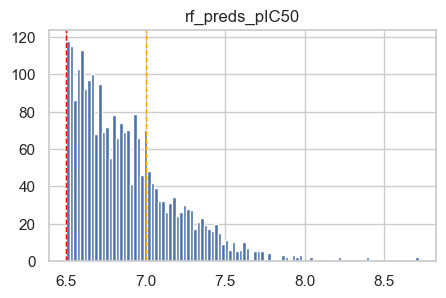

In [72]:
fig = lib_df_selected[["rf_preds_pIC50"]].hist(bins=100, figsize=(5,3))[0][0]
fig.axvline(6.5, color="red", linestyle="dashed", linewidth=1)
fig.axvline(7, color="orange", linestyle="dashed", linewidth=1)
print(
    "Number of compounds having predicted pIC50 greater than 6.5: ",
    lib_df_selected["rf_preds_pIC50"].gt(6).sum(),
)
print(
    "Number of compounds having predicted pIC50 greater than 7: ",
    lib_df_selected["rf_preds_pIC50"].gt(7).sum(),
)

In [135]:
# Exercise 4:  Multi-Objective Optimization

# This tutorial only uses the egfr binding affinity model for compound priotirization.
# In real drug design programs, compounds often are optimized for multiple objectives.
# Please use toy model at `data/toy_classifier.pkl` as second objective (optimize for label 1) and rank the compounds.
# You can use the ranking algorithm `MOORA` which is available at script `moora.py`.

# === YOUR CODE GOES HERE ===
with open('model/toy_classifer.pkl', 'rb') as f:
    fp_transfomer, toy_model = pickle.load(f)

lib_df['pred_label'] = dm.utils.parallelized_with_batches(
    fn = lambda mol: score(mol, fp_transfomer, toy_model, is_reg=False),
    inputs_list = lib_df.smiles.values,
    progress = True,
    batch_size = 100)
# === END ===

  0%|                                               | 0/240 [00:00<?, ?it/s]python(47900) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47901) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47902) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(47907) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|█████████████████████████████████████| 240/240 [00:20<00:00, 11.54it/s]


In [133]:
# del lib_df['pred_label']

In [136]:
lib_df.head()

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50,pred_label
0,Nc1nc2c(Cl)c(Cl)ccc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1ceff0>,Z57603637,1252574-R-230,A02,219.091,3.141,1,38.91,0,5.496237,0.104172
1,c1ccc(Nc2nccs2)nc1,<rdkit.Chem.rdchem.Mol object at 0x32c1cd5b0>,Z57595474,1252574-R-135,E06,177.226,1.806,1,37.81,2,5.953200,0.147049
2,Nc1nc2c(F)c(F)c(F)cc2s1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfed0>,Z56786333,1252574-R-162,E11,204.172,2.125,1,38.91,0,5.485877,0.135035
3,Cc1csc(Nc2ccccc2)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1cfdf0>,Z48853893,1252574-R-230,C05,190.265,3.511,1,24.92,2,5.324400,0.142639
4,NC(=O)CSc1nc(N)nc(N)n1,<rdkit.Chem.rdchem.Mol object at 0x32c1ce110>,Z17559442,1252574-R-156,B08,200.222,-1.545,3,133.80,3,4.988600,0.027276


array([[<Axes: title={'center': 'pred_label'}>]], dtype=object)

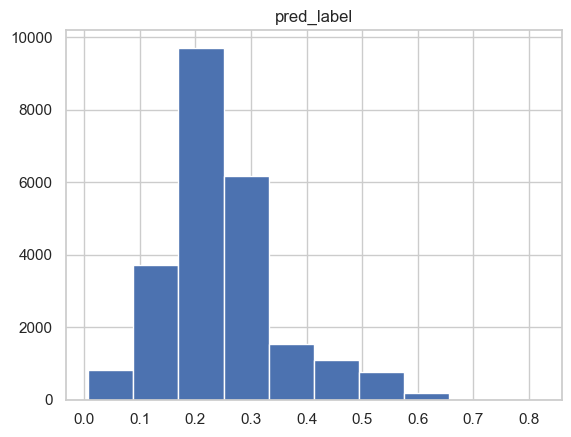

In [137]:
lib_df[['pred_label']].hist(bins=10)

In [ ]:
# @TODO
# rank compounds using MOORA

### Distribution in chemical space
Now let's check the distribution of training set and prioritized molecules in chemical space.

/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


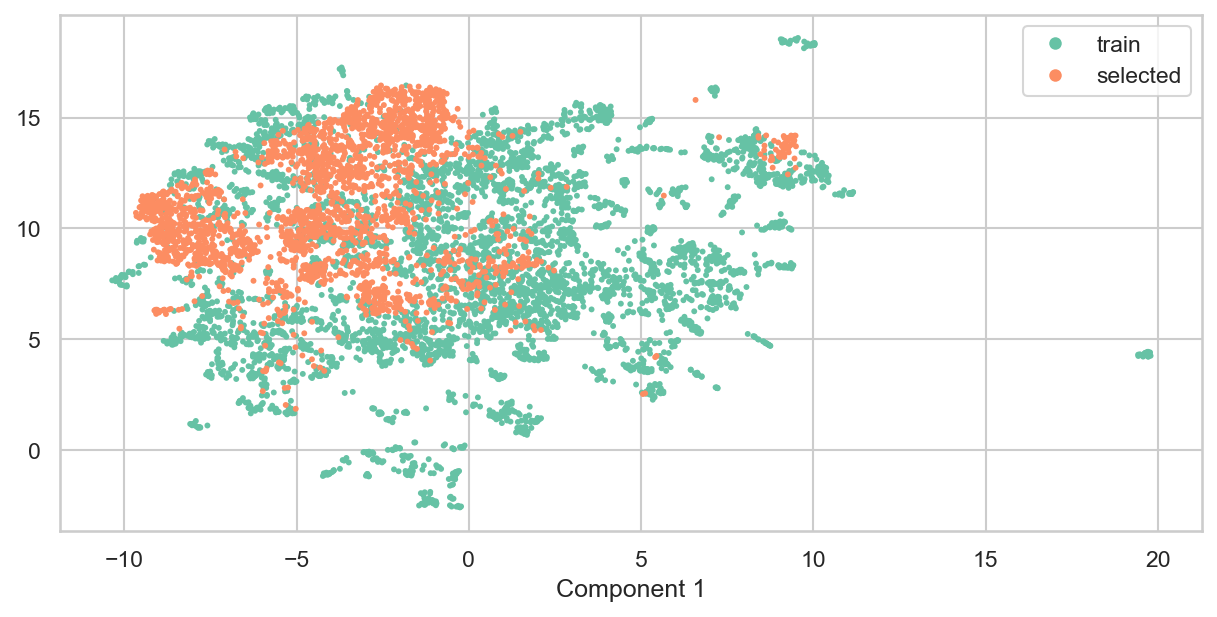

In [118]:
from chemspace_viz import visualize_chemspace

# compute the molecule features
train_feat = fp_transformer(data_train["MOL_smiles"])
lib_feat = fp_transformer(lib_df_selected["mol"])

fig = visualize_chemspace(
    X=np.concatenate([train_feat, lib_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(lib_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

The prioritized molecules (highlighted in orange) are mainly distributed in one cluster in the middle. 
Now we can use the predicted `pIC50` value to rank order the screened compounds and select a diverse set of these molecules for furture steps. 

#### Diverse pick of selected molecules
In drug discovery and development, selecting a diverse set of molecules is a critical step to ensure a comprehensive exploration of chemical space. This diversity maximizes the chances of identifying promising lead compounds with varying structural and functional characteristics. 

In [119]:
# Rank the molecules by pIC50
lib_df_selected = lib_df_selected.sort_values(
    by="rf_preds_pIC50", ascending=False
).reset_index(drop=True)

In [120]:
# Select 100 most diverse molecules from the set
picked_index, _ = dm.pick_diverse(
    mols=lib_df_selected.mol.values, npick=100, initial_picks=range(5)
)
lib_df_selected = lib_df_selected.iloc[picked_index]

/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/olawaleonabola/anaconda3/envs/mtl_summer/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


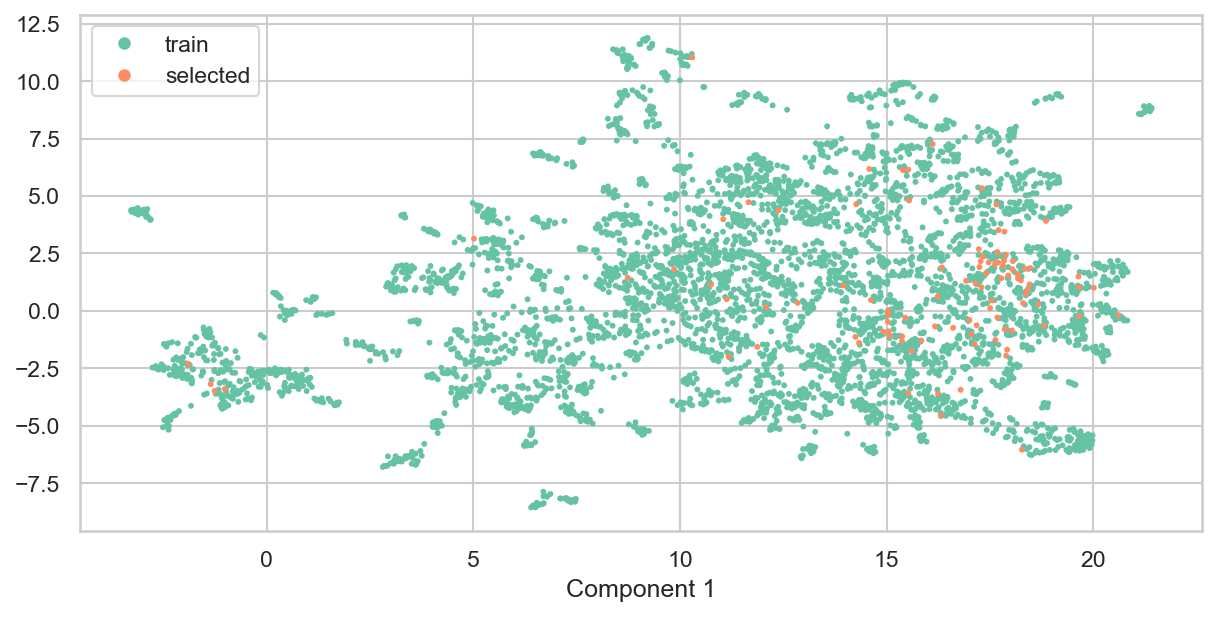

In [121]:
picked_feat = fp_transformer(lib_df_selected["mol"])
fig = visualize_chemspace(
    X=np.concatenate([train_feat, picked_feat]),
    y=np.array(["train"] * len(train_feat) + ["selected"] * len(picked_feat)),
    metric="jaccard",
    min_dist=0.5,
    random_state=42,
)

In [122]:
lib_df_selected

,smiles,mol,Catalog ID,PlateID,Well,MW (desalted),CLogP,HBD,TPSA,RotBonds,rf_preds_pIC50,uid
0,Cc1cc(Br)c2ncnc(NCCN3CCC(CO)C3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x400097220>,Z3834334774,1252574-R-295,A03,365.268,2.684,2,61.28,5,8.715450,57ffe0b27c7586b0aff4a869325a421f
1,Brc1ccc2ncnc(NCCCCN3CCOCC3)c2c1,<rdkit.Chem.rdchem.Mol object at 0x3cac07300>,Z729046120,1252574-R-255,H04,365.268,3.314,1,50.28,6,8.705750,ce539159f9617aeba030784ee34608f6
2,CCCCNC(=O)Cc1nc2cc(Br)ccc2c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x4000757e0>,Z2752947780,1252574-R-259,H05,338.200,1.361,2,70.56,5,8.455500,bb0a16adec9b00162827617eb494f91f
3,CC(C)NC(=O)Cc1nc2cc(Br)ccc2c(=O)[nH]1,<rdkit.Chem.rdchem.Mol object at 0x400075770>,Z2752947777,1252574-R-279,F05,324.173,0.612,2,70.56,3,8.428233,ca474b3acce4ddd4b54af9f7a520a2d4
4,Brc1ccc2c(NC3CC4(CCC4)C3)ncnc2c1,<rdkit.Chem.rdchem.Mol object at 0x4000992a0>,Z4126469215,1252574-R-248,G07,318.212,4.569,1,37.81,2,8.401091,e1143b38a754b27bebea9112faa5a15c
...,...,...,...,...,...,...,...,...,...,...,...,...
1257,CN(c1ncnc2cc(-c3ccc(F)cc3)sc12)C1CCCCC1,<rdkit.Chem.rdchem.Mol object at 0x3cac0adc0>,Z31198047,1252574-R-093,G07,341.446,6.287,0,29.02,3,6.812773,18ade49147d0b5854106806fe5bb5b8a
1659,Cc1ccc2nc(CNc3cc(Cl)ccc3F)cc(=O)n2c1,<rdkit.Chem.rdchem.Mol object at 0x3cac04430>,Z217280572,1252574-R-120,A06,317.745,3.083,1,44.70,3,6.690012,17813eb63f3ba3db7000594a2c5ed33a
2212,Cc1cnc(C)c(N2CCN(c3cc(C4CC4)n[nH]3)CC2)n1,<rdkit.Chem.rdchem.Mol object at 0x400044ba0>,Z1743914361,1252574-R-246,E06,298.386,2.206,1,60.94,3,6.563407,2ccdb4d85341c5e3c86538a62cc72bd3
1730,CC(Nc1ncnc2c(F)cccc12)c1ccc(N2CCCS2(=O)=O)cc1,<rdkit.Chem.rdchem.Mol object at 0x400052f10>,Z1874260309,1252574-R-113,H11,386.443,2.770,1,75.19,4,6.669775,76ec08b132acd543896898ba8400a473


Now we visualize the picked molecules.

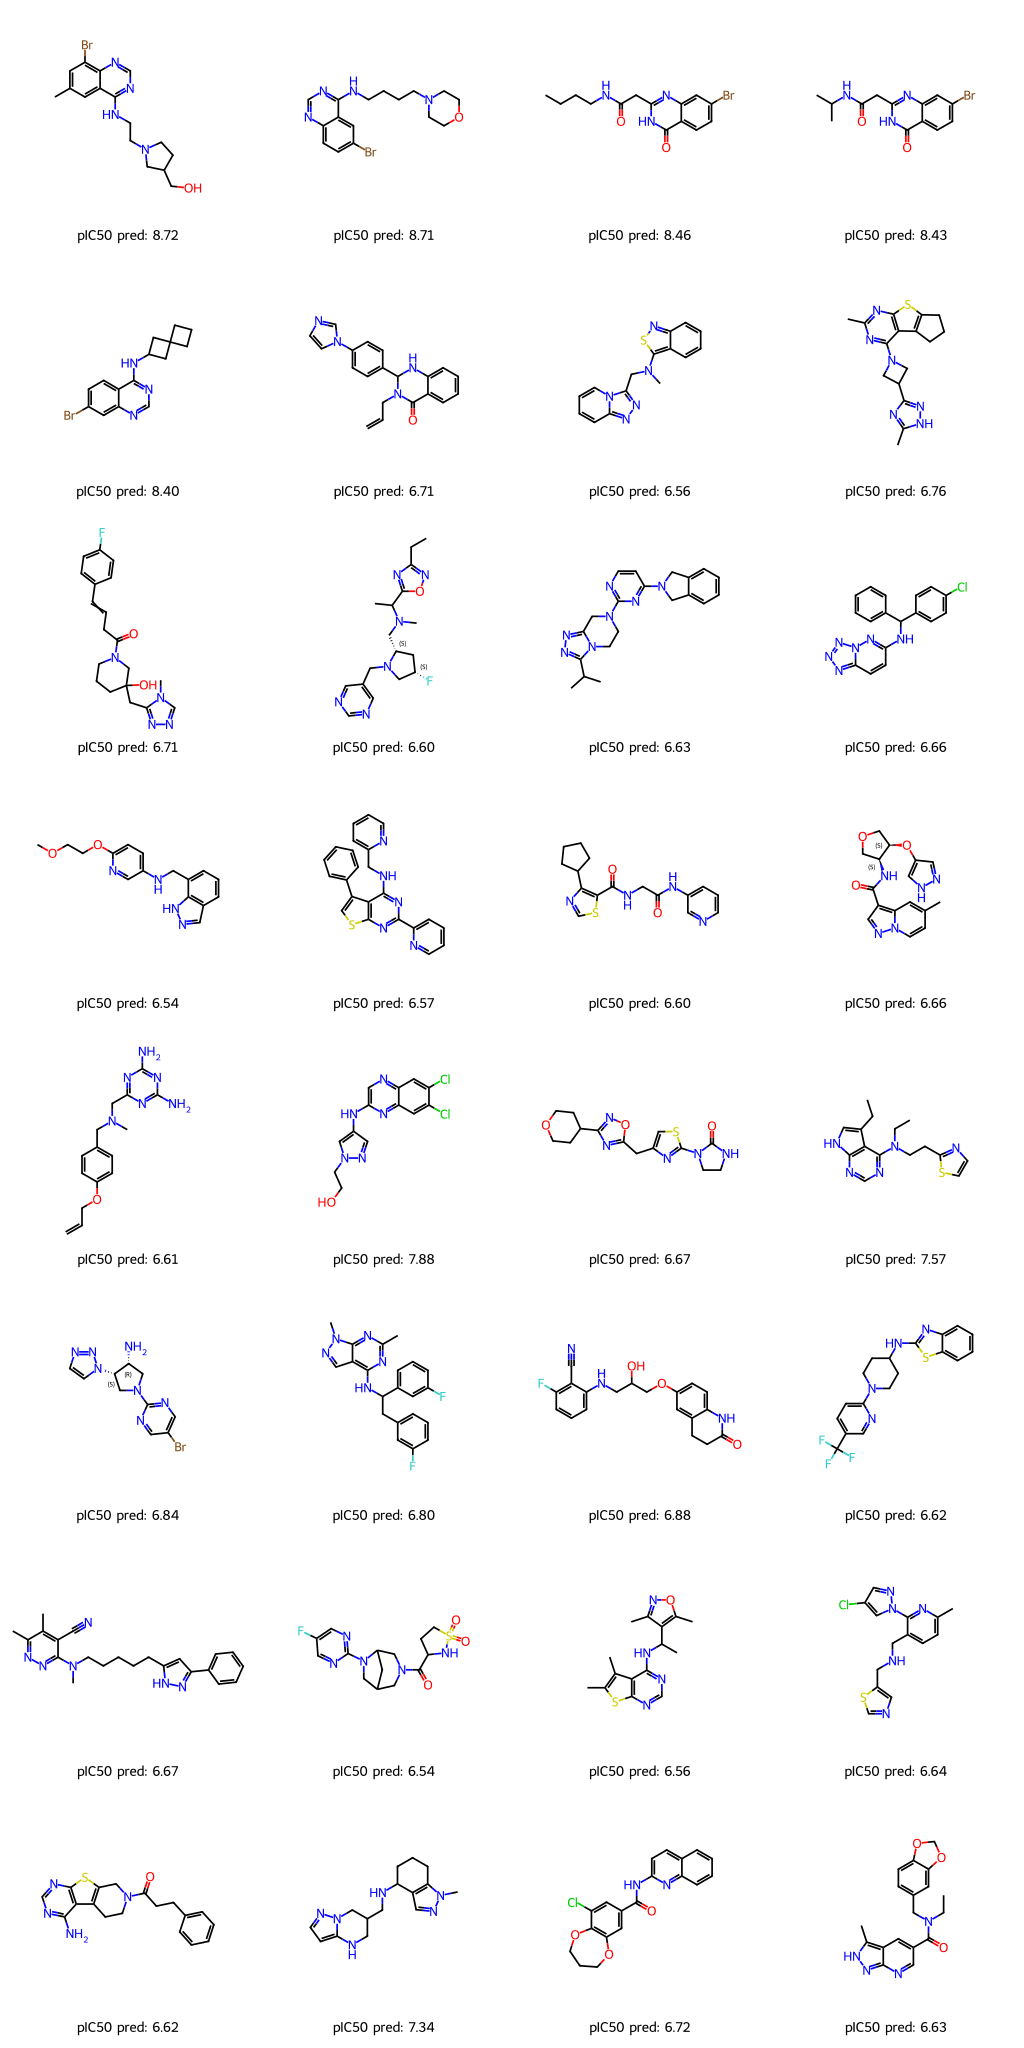

In [124]:
legends = (
    lib_df_selected["rf_preds_pIC50"]
    .apply(lambda x: "pIC50 pred: {:,.2f}".format(x))
    .tolist()
)
dm.to_image(lib_df_selected.mol.tolist(), legends=legends)


Our models could be used to rank the compounds and then further study those with the highest predicted binding affinity.


In [125]:
# Export the selected molecules
import os

os.makedirs("output", exist_ok=True)
lib_df_selected.drop(columns="mol").to_csv("output/picked100mols.csv", index=False)

In [53]:
### In this tutorial, the molecules were filtered only by the predicted inhibition pIC50 values and molecular weight.
### In pratice, scientist often apply medchem filters to prioritize molecules which are more druglike.
### Check out https://github.com/datamol-io/medchem